In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
Z = np.array([[1,0],[0,-1]])
Y = np.array([[0,-1.j],[1.j,0]])
X = np.array([[0,1],[1,0]])
I = np.eye(2)

H = Z + np.eye(2) # Shift Hamiltonian so its spectrum is [0, lambda_1, ...]; non-negative

Generate random 1-qubit normalized wavefunction.

In [3]:
psi = np.random.rand(2) + 1.j*np.random.rand(2)
#psi = np.array([0,1], dtype=np.float64)
psi /= np.linalg.norm(psi)
print(psi)

[0.6241809 +0.60370523j 0.34513954+0.3561136j ]


In [4]:
GS = np.array([0,1]) # Ground state of H = Z
E_GS = GS @ H @ GS
print(E_GS)

0.0


In [5]:
print(psi.conj() @ H @ psi) # Initial energy
print(np.abs(psi.conj().T @ GS)**2) # Initial overlap**2

(1.5081236033282286+0j)
0.2459381983358858


# Block encoding

In [6]:
beta = 0.1
gamma = sp.linalg.expm(-beta*H) # Diagonal ITE matrix
print(gamma)

[[0.81873075 0.        ]
 [0.         1.        ]]


In [7]:
U_gamma = np.zeros((4,4), dtype=gamma.dtype) # 2-qubit block encoding; no controlled permutation
U_gamma[:2,:2] = gamma
#U_gamma[2:,:2] = U_gamma[:2,2:] = sp.linalg.fractional_matrix_power(1 - sp.linalg.fractional_matrix_power(gamma, 2.0), 0.5)
U_gamma[2:,:2] = U_gamma[:2,2:] = np.sqrt(np.eye(2) - gamma**2)
U_gamma[2:,2:] = -gamma

In [8]:
sp.linalg.fractional_matrix_power(1 - sp.linalg.fractional_matrix_power(gamma, 2.0), 0.5)

array([[0.63103225+0.38569605j, 0.53552872-0.45447916j],
       [0.53552872-0.45447916j, 0.45447916+0.53552872j]])

In [9]:
np.sqrt(np.eye(2) - gamma**2)

array([[0.57417763, 0.        ],
       [0.        , 0.        ]])

In [10]:
np.linalg.norm(U_gamma @ U_gamma.conj().T - np.eye(4)) # Check that it's unitary

2.429468200843727e-17

# Enlarged state

In [11]:
psiA = np.kron(np.array([1,0]), psi) # |Psi>|0> -> tensor on the ancilla qubit in |0>
print(psiA)

[0.6241809 +0.60370523j 0.34513954+0.3561136j  0.        +0.j
 0.        +0.j        ]


In [12]:
# Pre measurement
print(np.linalg.norm(psiA[:2])**2) # probability of measuring ancilla 0
print(np.linalg.norm(psiA[2:])**2) # probability of measuring ancilla 1

1.0
0.0


In [13]:
psiB = U_gamma @ psiA # apply block encoding

In [14]:
# Post measurement
print(np.linalg.norm(psiB[:2])**2) # probability of measuring ancilla 0
print(np.linalg.norm(psiB[2:])**2) # probability of measuring ancilla 1

0.7514009399410919
0.24859906005890806


In [15]:
psiB[:2] - gamma @ psi

array([0.+0.j, 0.+0.j])

In [16]:
psiB[2:] - U_gamma[2:,:2] @ psi

array([0.+0.j, 0.+0.j])

In [17]:
psiB[:2] # Unnormalized state upon 0 ancilla measurement

array([0.5110361 +0.49427204j, 0.34513954+0.3561136j ])

In [18]:
psiB[2:] # Unnormalized state upon 1 ancilla measurement

array([0.35839071+0.34663404j, 0.        +0.j        ])

# Modified BE

In [19]:
CP = np.eye(4, dtype=gamma.dtype)
CP[2:,2:] = np.roll(np.eye(2), 1, axis=1) # Swap 1 qubit eigenstates; X in eigenbasis

In [20]:
CP

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [21]:
V_gamma = CP @ U_gamma

In [22]:
np.linalg.norm(V_gamma @ V_gamma.conj().T - np.eye(4))

2.429468200843727e-17

In [23]:
V_gamma

array([[ 0.81873075,  0.        ,  0.57417763,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.        ],
       [ 0.57417763,  0.        , -0.81873075,  0.        ]])

In [24]:
psiC = V_gamma @ psiA

In [25]:
# Probabilities post measurement are the same with naive and conditional BE; this has to be since we multiplied by a unitary
print(np.linalg.norm(psiC[:2])**2)
print(np.linalg.norm(psiC[2:])**2)

0.7514009399410919
0.24859906005890806


In [26]:
psiC[:2] - gamma @ psi

array([0.+0.j, 0.+0.j])

In [27]:
psiC[2:] - U_gamma[2:,:2] @ psi

array([-0.35839071-0.34663404j,  0.35839071+0.34663404j])

In [28]:
psiC[2:] - V_gamma[2:,:2] @ psi

array([0.+0.j, 0.+0.j])

In [29]:
psiC[2:]

array([0.        +0.j        , 0.35839071+0.34663404j])

# Run optimization algorithm

In [30]:
# Function that does many steps
def HITE(psi, beta, H, max_iter, adaptive=True, force_fail=False, verbose=False, seed=0):
    if seed >= 0:
        np.random.seed(seed)
    d = H.shape[0]
    L, U = np.linalg.eigh(H) # Energy eigenbasis
    GS = U[:,0]

    # Shift spectrum of H to be non-negative with GS energy being 0
    H_diag = np.diag(L)
    H_diag -= np.min(L) * np.eye(d)

    print(f"Spectrum: {np.diag(H_diag)}.")
    assert np.isclose(GS.conj().T @ H @ GS, np.min(L))
    
    # Make gamma = e^{-beta H_diag)
    gamma = sp.linalg.expm(-beta * H_diag)
    U_gamma = np.zeros((2*d,2*d), dtype=gamma.dtype)
    U_gamma[:d,:d] = gamma
    U_gamma[d:,:d] = U_gamma[:d,d:] = np.sqrt(np.eye(d) - gamma**2)
    U_gamma[d:,d:] = -gamma
    assert np.isclose(np.linalg.norm(U_gamma @ U_gamma.conj().T - np.eye(2*d)), 0.0)
    
    psi = U.conj().T @ psi # Move to energy eigenbasis
    GS_E = U.conj().T @ GS # GS in energy eigenbasis. Should just be [1,0,0,...]
    assert np.isclose(GS_E[0], 1)
    
    Es = [psi.conj().T @ H_diag @ psi] # Initial energy
    Fs = [np.abs(psi[0])**2]
    if verbose:
        print(f"Energy at iteration {0}: {Es[-1]}.")
    
    mos = []
    fail_count = 0
    def permutation(fail_count, d):
        # Define one particular choice of permutation matrix
        P = np.eye(d)
        if fail_count == 0:
            P = np.roll(np.eye(d), 1, axis=1)
        else:
            P[:-fail_count,:-fail_count] = np.roll(P[:-fail_count,:-fail_count], 1, axis=1)
        return P
    
    for i in range(1, max_iter+1):
        #print(psi)
        psi_E = np.kron(np.array([1,0]), psi)
        psi_E = U_gamma @ psi_E
        p0 = np.linalg.norm(psi_E[:d])**2
        p1 = np.linalg.norm(psi_E[d:])**2
        assert np.isclose(p0 + p1, 1)

        # Choose measurement outcome according to probabilities
        mo = np.random.choice([0,1], size=1, p=[p0,p1])[0]
        if p1 > 0 and force_fail:
            mo = 1
        mos.append(mo)
        if verbose:
            print(f"Measurement outcome and probability at iteration {i}: {mo}, {[p0,p1][mo]}.")
        
        if mo == 0:
            psi = psi_E[:d]
        else:
            psi = psi_E[d:]
        psi /= np.linalg.norm(psi)

        if mo == 1 and adaptive:
            # Made measurement error; try to fix
            nP = permutation(fail_count, d)
            assert np.isclose(np.linalg.norm(nP @ nP.conj().T - np.eye(d)), 0.0)
            psi = nP @ psi
            fail_count += 1
            print(f"-------fail counter: {fail_count}; iteration: {i}-------")
        Es.append(psi.conj().T @ H_diag @ psi)
        Fs.append(np.abs(psi[0])**2)
        if verbose:
            print(f"Energy at iteration {i}: {Es[-1]}.")
        if len(Es) > 1 and np.abs(Es[-1] - Es[-2]) < 1.e-8:
            break
    if np.isclose(Es[-1], 0):
        assert np.isclose(np.abs(GS.conj().T @ (U @ psi)), 1.0)
        assert np.isclose((U @ psi).conj().T @ H @ (U @ psi), np.min(L))
    return Es, Fs, mos, U @ psi

## 1-qubit check

In [31]:
psi = np.random.rand(2) + 1.j*np.random.rand(2)
psi /= np.linalg.norm(psi)
print(psi)

[0.79868425+0.52026014j 0.00721356+0.30229259j]


In [32]:
np.abs(psi[1])**2

0.09143284799668175

Spectrum: [0. 2.].
-------fail counter: 1; iteration: 1-------


/home/sajant/miniconda3/envs/DMT/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sajant/miniconda3/envs/DMT/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Energy: 0.0, Fidelity: 1.0000000000000004')

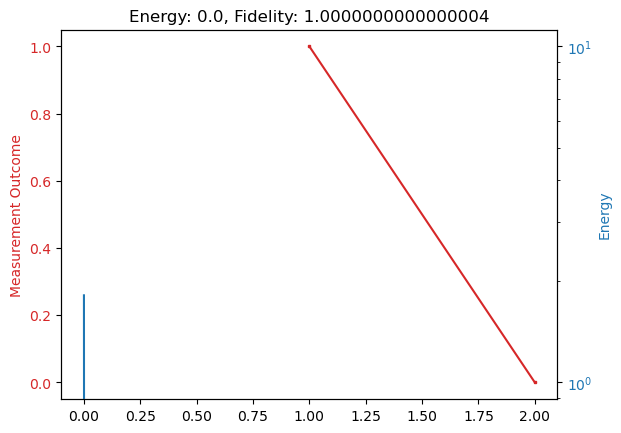

In [33]:
Es, Fs, mos, _ = HITE(psi, 1, Z, 100, seed=-1)
fig = plt.figure()

ax = fig.gca()
color = 'tab:red'
ax.plot(np.arange(1, len(mos)+1), np.array(mos), marker='s', markersize=2, color=color)
ax.set_ylabel('Measurement Outcome', color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()
color = 'tab:blue'
ax2.plot(Es, color=color)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy', color=color)
ax2.set_yscale('log')

ax2.tick_params(axis='y', labelcolor=color)
ax.set_title(f"Energy: {Es[-1].real}, Fidelity: {Fs[-1]}")

In [34]:
Fs

[0.09143284799668175, 0.9999999999999998, 1.0000000000000004]

In [35]:
plt.close('all')

## $n$-qubit case

In [36]:
def kron(ops):
        op = 1
        for o in ops:
            op = np.kron(op, o)
        return op

Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1.j],[1.j,0]])
Id = np.eye(2)

def build_Hamiltoinan(L, Jz, hx, hz):
    # Build full 2^L x 2^L Hamiltonian

    H = np.zeros((2**L, 2**L), dtype=np.float64)

    for i in range(L):
        H += hx * kron([Id]*i + [X] + [Id]*(L-i-1))
        H += hz * kron([Id]*i + [Z] + [Id]*(L-i-1))

    Ising = [Z, Z] + [Id] * (L-2)
    for i in range(L):
        H += Jz * kron(Ising)
        # Shift the first element to the last; periodic BCs!
        Ising.append(Ising.pop(0))
    return H
L = 5
H = build_Hamiltoinan(L, -1, -1, 0)
d = H.shape[0]

In [37]:
psi = np.random.rand(d) + 1.j*np.random.rand(d)
psi /= np.linalg.norm(psi)
#print(psi)

Spectrum: [ 0.          0.31676888  2.47213595  2.66790989  2.66790989  4.12099495
  4.12099495  4.47213595  4.47213595  4.47213595  4.47213595  5.0190509
  5.23606798  5.23606798  6.47213595  6.47213595  6.47213595  6.47213595
  6.47213595  7.23606798  7.23606798  7.92522101  8.82327696  8.82327696
  8.94427191  9.70820393  9.70820393 10.27636202 10.27636202 11.70820393
 11.70820393 12.62750303].
-------fail counter: 1; iteration: 2-------
-------fail counter: 2; iteration: 3-------


Text(0.5, 1.0, 'Energy: 2.3887829488333142e-08, Fidelity: 0.9999999245890902')

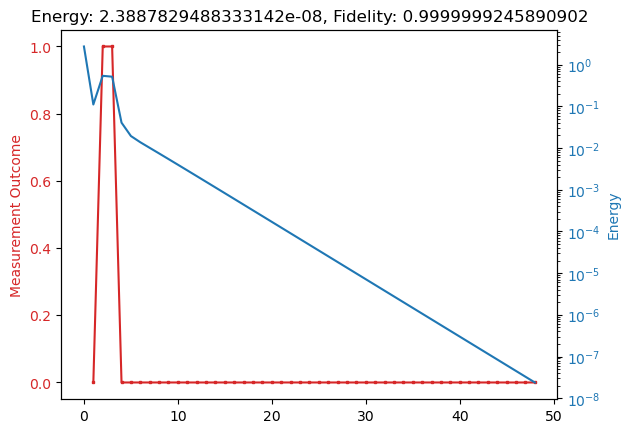

In [38]:
Es, Fs, mos, _ = HITE(psi, 0.5, H, 10000, adaptive=True, force_fail=False, seed=-1)
fig = plt.figure()

ax = fig.gca()
color = 'tab:red'
ax.plot(np.arange(1, len(mos)+1), np.array(mos), marker='s', markersize=2, color=color)
ax.set_ylabel('Measurement Outcome', color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()
color = 'tab:blue'
ax2.plot(Es, color=color)
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Energy', color=color)
ax2.set_yscale('log')

ax2.tick_params(axis='y', labelcolor=color)
ax.set_title(f"Energy: {Es[-1].real}, Fidelity: {Fs[-1]}")